
# <ins>"Выбор подходящего тарифа"</ins>
___
В исходном файле представленна таблица, описывающая данные о поведении клиентов уже перешедших на целевые тарифы.
### Содержание
___
<a id='top'></a>
1. [Постановка задачи](#1)
2. [Общая информация о данных](#2)
3. [Разведочный анализ данных и разделение датасета](#3)
4. [Исследование качества моделей](#4)
 * 4.1 [Модель "Решающее дерево"](#4.1)
 * 4.2 [Модель "Случайный лес"](#4.2)
 * 4.3 [Модель "Логистическая регрессия"](#4.3)
5. [Проверка качества на тестовой выборке](#5)
6. [Проверка модели на вменяемость](#6)
7. [Вывод](#7)

<a id='1'></a>

## 1. Постановка задачи
Необходимо построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

<a id='2'></a>

## 2. Общая информация о данных

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [19]:
# прочитаем файлы:

try:
    df = pd.read_csv("users_behavior.csv")
except:
    try:
        df = pd.read_csv("/datasets/users_behavior.csv")
    except:
        df = pd.read_csv("https://code.s3.yandex.net/datasets/users_behavior.csv")
        
display(df.head())
print()
print(df.info())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Таким образом для каждого из 3214 клиентов мы знаем количество звонков, минут, сообщений и мегабайт-интернет трафика, а также каким тарифом пользуется клиент (если 0 то Смарт, если 1 то Ультра).  
По условию данные в предобработке не нуждаются. Пропусков в них нет.

<a id='3'></a>

## 3. Разведочный анализ данных и разделение датасета

**Посмотрим как распределены наши данные**

Для этого построим частотные гистограммы.

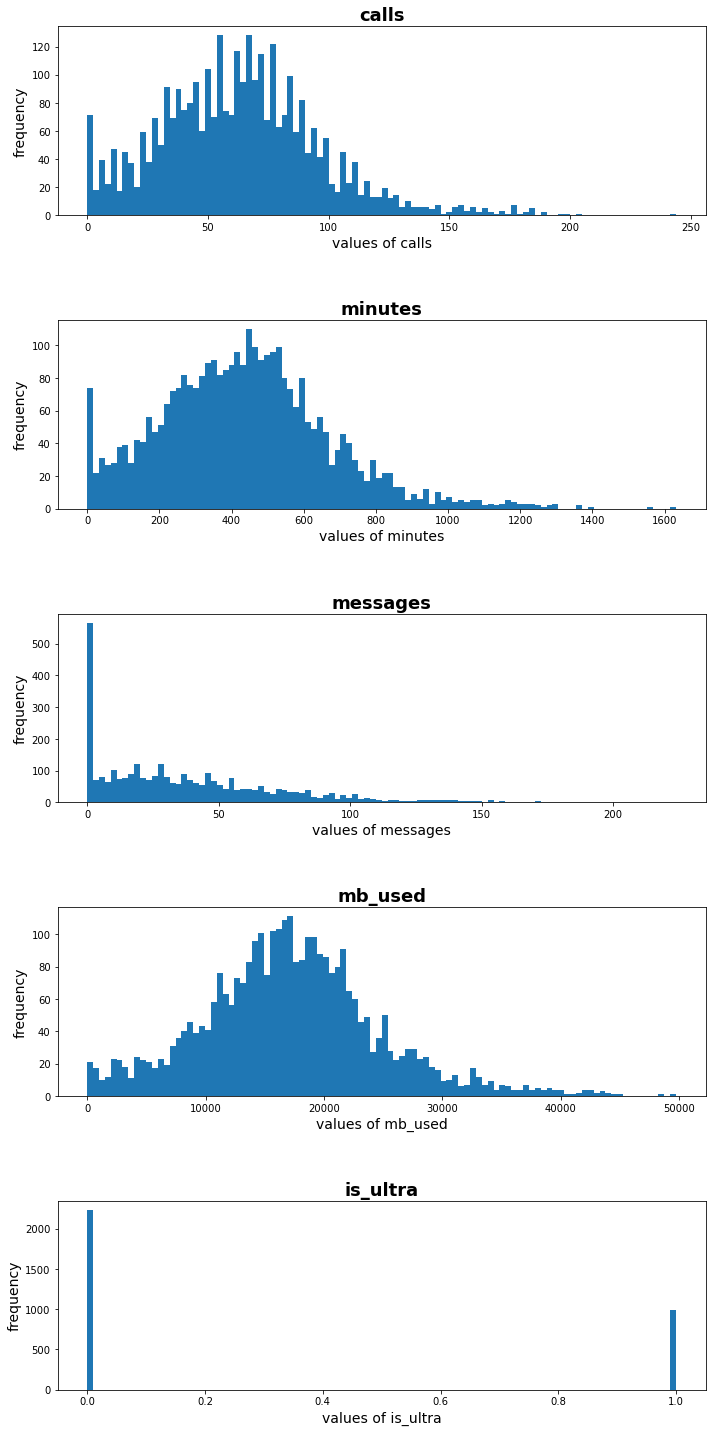

In [20]:
fig, subplots = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

columns = df.columns
i = -1
for ax in fig.axes:
    i += 1
    ax.hist(df[columns[i]], bins=100)
    
    ax.set_title(columns[i], fontsize=18, fontweight="bold")
    ax.set_xlabel('values of ' + columns[i], fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    
plt.tight_layout(h_pad = 5)

plt.show()

Как видно из графиков в столбцах "calls", "minutes" и "messages" довольно много нулевых значений.

В случае с "messages" это нормально - сейчас мало кто использует смс.

Посмотрим на данные в нулевыми значениями в столбцах "calls" и "minutes"

In [21]:
df[df['minutes']==0]

,calls,minutes,messages,mb_used,is_ultra
54,0.0,0.0,33.0,14010.33,1
247,0.0,0.0,35.0,16444.99,1
264,0.0,0.0,21.0,19559.55,0
351,0.0,0.0,8.0,35525.61,1
390,0.0,0.0,25.0,19088.67,1
484,0.0,0.0,191.0,32448.02,1
551,0.0,0.0,24.0,18701.54,1
647,0.0,0.0,30.0,10236.20,1
769,0.0,0.0,32.0,17206.44,0
884,0.0,0.0,180.0,32045.73,1


Как можно заметить данные по сообщениям и интрнет-трафику в этих строках присутствуют. Вероятнее всего на месте нулевых значений были пропуски и их заменили на ноль.  
Фактически в нашей задаче эти данные даже не бесполезны, а вредны. Т.к. они будут лишь запутывать модель, которая будет пытаться обобщить данные.

В столбце "is_ultra" можно заметить, что данные количественно распределены неравномерно между тарифами. Т.е. данных по тарифу Смарт более чем в 2 раза больше чем данных Ультра. Это не очень хорошо, т.к. при разбиении датасета на выборки мы можем получить, например, очень малое количество данных Ультра в обучающей выборке и модель плохо обучится.

**Посмотрим на взаимосвязи признаков**

Выделим признаки в отдельный датасет, построим график матрицы рассеяния и вычислим коэффициент корреляции между признаками.

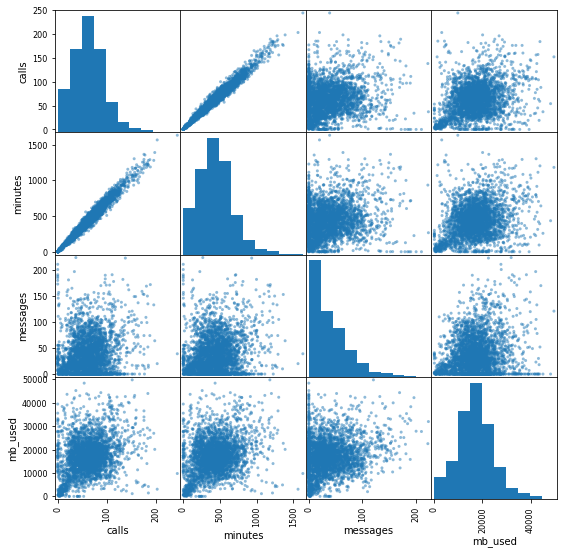

In [22]:
df_features = df.copy()

# удаляем целевой признак
del df_features['is_ultra']

# строим матрицу рассеяния между признаками
pd.plotting.scatter_matrix(df_features, figsize=(9, 9))

plt.show()

In [23]:
# строим матрицу корреляции между признаками

round(df_features.corr(), 2).style.background_gradient('coolwarm')

,calls,minutes,messages,mb_used
calls,1.000000,0.980000,0.180000,0.290000
minutes,0.980000,1.000000,0.170000,0.280000
messages,0.180000,0.170000,1.000000,0.200000
mb_used,0.290000,0.280000,0.200000,1.000000


По графику наблюдается сильная прямая взаимосвязь между количеством совершенных звонков и количеством использованных минут, коэффициент корреляции 0,98. Это логично.

Но эта пара признаков является избыточной, т.к. сильно коррелирует друг с другом. Это явление носит название мультиколлинеарности. Удаление одной переменной в таких парах признаков часто помогает модели обобщать и быть более интерпретируемой.

**Исходя из вышепроведенных исследований данных сделаем следующее:**

 * Из пары сильно коррелирующих признаков удалим признак "calls". Количество звонков не является определяющим параметром тарифа, а остальные признаки являются и ограничения по их использованию входят в пакет услуг тарифа.
 * Удалим из таблицы все строки у которых количество использованных минут равно нулю. Так модель вернее определит закономерности между признаками.

In [24]:
del df['calls']

In [25]:
df = df.query('minutes > 0')

In [26]:
df[df['minutes']==0]['minutes'].count()

0

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3174 non-null   float64
 1   messages  3174 non-null   float64
 2   mb_used   3174 non-null   float64
 3   is_ultra  3174 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 124.0 KB


**Разобьем исходные данные на три выборки: обучающую, валидационную (проверочную) и тестовую**

В sklearn для этого предусмотрена функция **train_test_split**. Она разбивает любой датасет на обучающую и тестовую выборки.  
Т.к. нам нужно разделить датасет на три части, то деление будет происходить в два этапа. Сначала разделим на обучающий набор и проверочный в соотношении 60%:40%. Затем проверочный набор поделим пополам на валидационный набор и тестовый.

Зададим параметр random_state чтобы можно было воспроизвести это псевдослучайно разбиение данных.

In [28]:
df_train, df_check = train_test_split(df, test_size=0.4, random_state=12345)

In [29]:
df_valid, df_test = train_test_split(df_check, test_size=0.5, random_state=12345)

In [30]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1904, 4)
(635, 4)
(635, 4)


Теперь у нас есть три ддатасета:

`df_train` для обучения модели  
`df_valid` для поверки модели на переобучение  
`df_test` для оценки качества модели

<a id='4'></a>

## 4. Исследование качества моделей

Рассмотрим наши данные с точки зрения построения прогностической модели.

В качестве целевого признака выступает столбец "is_ultra". Т.к. в нем отражено какой тариф использует клиент, Смарт или Ультра, следовательно этот признак является категориальным. Следовательно нам необходимо решить задачу **классификации**, а точнее **бинарной классификации** (т.к. целевых признаков всего два).

Чтобы предложить клиенту новый тариф мы должны предположить как работают взаимосвязи признаков у пользователей этих новых тарифов. На основании этих предположений сможем  предсказать какой тариф предложить клиенту. Если эти предсказания соответсвуют реальности, то мы на верном пути и наши предположения верны.  
Такой подход называется моделированием, а сами предположения и способы предсказания — моделями машинного обучения.

В процессе моделирования будем использовать следующие модели машинного обучения:

 * Решающее дерево
 * Случайный лес
 * Логистическая регрессия
 
У "Решающего дерева" и "Случайного леса" есть гиперпараметры, меняя которые можно подобрать наилучшую модель. У "Решающего дерева" это максимальная глубина дерева `max_depth`. У "Случайного леса" к максимальной глубине добавляется еще один гиперпараметр количество деревьев `n_estimators`.

Каждую модель обучим на обучающем наборе и проверим на валидационной выборке. Таким образом определим лучшую модель.

Т.к. наборы данных для всех моделей у нас одинаковые, объявим переменные `features` и `target` (признаки и целевой признак), которым присвоим соответствующие им признаки.

In [31]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

<a id='4.1'></a>

### 4.1 Модель "Решающее дерево"

Построим модель "Решающего дерева". Гиперпараметр `max_depth` будем изменять в пределах от 2 до 15 в цикле.

In [32]:
# соберем значения accuracy в список, чтобы потом легко было извлечь максимольное занчение и соответствующую ему глубину дерева
accuracy_tree_list = []

for md_tree in range(2, 16):
    # определяем вид модели и ее гиперпараметры
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=md_tree)
    
    # обучаем модель на обучающем наборе данных
    model_tree.fit(features_train, target_train)
    
    # проверяем модель на валидационном наборе данных
    predictions_tree = model_tree.predict(features_valid)
    
    # считаем метрику accuracy, используя в качестве ответов целевой признак валидационного набора
    accuracy_tree = round(accuracy_score(target_valid, predictions_tree), 4)
    accuracy_tree_list.append(accuracy_tree)
    
print(accuracy_tree_list)
print()    
print('Максимальная доля правильных ответов', max(accuracy_tree_list), 'при max_depth =', np.argmax(accuracy_tree_list)+2)

[0.7638, 0.7701, 0.778, 0.7685, 0.7717, 0.7606, 0.7732, 0.7748, 0.7685, 0.7622, 0.7591, 0.7622, 0.737, 0.7307]

Максимальная доля правильных ответов 0.778 при max_depth = 4


Нашли лучший вариант - при глубине дерева 4 доля правильных ответов составляет 78%. Как видим при глубине дерева более 13 доля правильных ответов падает, что свидетельствует о перееобучаемости модели.

<a id='4.2'></a>

### 4.2 Модель "Случайный лес"

В модели "Случайный лес" применим два цикла. Первый цикл будет перебирать глубину дерева `max_depth`, а второй для каждой глубины дерева будет перебирать количества деревьев `n_estimators`.

In [33]:
# соберем значения accuracy и гиперпараметров в списки, из которых потом создадим датафрейм
accuracy_rf_list = []
max_depth_list = []
n_estim_list = []

for md_rf in range(2, 16):
    for ne_rf in range(2, 51):
        model_rf = RandomForestClassifier(random_state=12345, max_depth=md_rf, n_estimators=ne_rf)
        
        model_rf.fit(features_train, target_train)
        
        predictions_rf = model_rf.predict(features_valid)
        
        accuracy_rf = round(accuracy_score(target_valid, predictions_rf), 4)
        
        accuracy_rf_list.append(accuracy_rf)
        max_depth_list.append(md_rf)
        n_estim_list.append(ne_rf)

In [34]:
# собираем все списки в один
result_list = [max_depth_list, n_estim_list, accuracy_rf_list]

# создаем датафрейм
df_random_forest = pd.DataFrame({'max_depth':max_depth_list, 'n_estimators':n_estim_list, 'accuracy':accuracy_rf_list})

# из которого теперь легко вычленить интересующую нас информацию
# ввиду строки с максимальным значением accuracy и соответствующих гиперпараметров
display(df_random_forest[df_random_forest['accuracy']==df_random_forest['accuracy'].max()])

,max_depth,n_estimators,accuracy
210,6,16,0.8016


Самый лучший результат получили при глубине дерева 6 и количестве деревьев 16. Доля правильных ответов составляет 80%.

<a id='4.3'></a>

### 4.3 Модель "Логистическая регрессия"

In [35]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs')

model_lr.fit(features_train, target_train)

predictions_lr = model_lr.predict(features_valid)

accuracy_lr = round(accuracy_score(target_valid, predictions_lr), 4)
accuracy_lr

0.7402

Модель логистической регрессии показывает самый худший результат, 74% правильных ответов.

<a id='5'></a>

## 5 Проверка качества модели на тестовой выборке

Проверим как ведет себя лучшая модель случайного леса на тестовой выборке.

In [36]:
predictions_rf_test = model_rf.predict(features_test)

accuracy_rf_test = round(accuracy_score(target_test, predictions_rf_test), 4)
accuracy_rf_test

0.8283

83% правильных ответов. Даже больше чем на валидационном наборе.

<a id='6'></a>

## 6 Проверка модели на вменяемость

Всегда необходимо проверять модель на вменяемость (или адекватность). Делается это для того, чтобы знать, что наша построенная модель работает лучше случайных предсказаний. Иначе зачем она нужна.

В качестве случайных предсказаний создадим массив из нулей и единиц распределенных случайным образом и оценим качество таких предсказаний.

In [37]:
random_answers = np.random.randint(0, 2, size=635)

In [38]:
accuracy_random_test = round(accuracy_score(target_test, random_answers), 4)
accuracy_random_test

0.4913

Наша модель дает гораздо больше правильных ответов чем случайные предсказания.

<a id='7'></a>

## 7 Вывод

В данном проекте мы провели разведочный анализ исходных данных. Благодаря этому удалось выявить избыточные признаки и нерепрезентативные данные. Удаление этих данных из датасета способствовало модели выявлять закономерности в признаках и увеличило ее качество.

Мы рассмотрели три модели: "Решающее дерево", "Случайный лес" и "Логистическая регрессия". В каждой модели, изменяя ее гиперпараметры, мы нашли нашли лучший вариант с наибольшим количеством правильных ответов. Путем простого сравнения лучших моделей по доле правильных ответов определили, что для нашей задачи подходит модель "Случайного леса" с гиперпараметрами глубина дерева 6 и количество деревьев 16.

Сравнив нашу модель со случайными предсказаниями и оценив ее качество на тестовом наборе данных (результат составил 82% правильных ответов) мы подтвердили, что наша модель подходит для задачи заказчика. Таким образом можно использовать данную модель для предложения клиентам заказчика нового тарифа ("Смарт" или "Ультра").